# Skin Detection System V1

Start Date - 10 March 2025.
End Date -

Initial test for using this dataset from Kaggle by Shubham Goel : https://www.kaggle.com/datasets/shubhamgoel27/dermnet?select=train


In [ ]:
# pip install torch; torchvision; kagglehub

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shubhamgoel27/dermnet")

# print("Path to dataset files:", path)

## Initial Data Loading


In [20]:
import torch
import torchvision
from torchvision import transforms
from pathlib import Path
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
data = Path("Data")
image_path = data/"Diseases_Split"

train_dir = image_path/"train"
test_dir = image_path/"test"

## Converting to Datasets & DataLoaders


In [5]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=25),
    transforms.ToTensor(),
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder(train_dir,
                                                 transform=simple_transform,
                                                 target_transform=None)

test_dataset = torchvision.datasets.ImageFolder(test_dir,
                                                 transform=simple_transform,
                                                 target_transform=None)

img, label = train_dataset[0][0], train_dataset[0][1]

img.shape

torch.Size([3, 224, 224])

In [7]:
class_names = train_dataset.classes

Text(0.5, 1.0, 'Acne and Rosacea Photos')

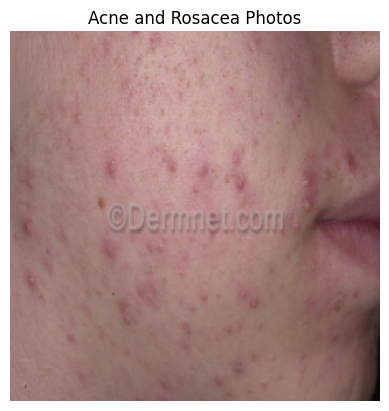

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

In [9]:
import os
os.cpu_count()

8

In [35]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=4)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1d9dacf2a10>,
 <torch.utils.data.dataloader.DataLoader at 0x1d9dacf2f50>)

## Model


In [26]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# Initialize model
model_0 = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

model_0.classifier[1].out_features = len(class_names)
model_0

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [27]:
img.shape

torch.Size([3, 224, 224])

In [28]:
model_0(img.unsqueeze(dim=0)).shape

torch.Size([1, 1000])

In [29]:
len(class_names)

23

## Functionalizing Training and Testing Functions


In [30]:
from tqdm.auto import tqdm

In [38]:
def train_step(model: nn.Module,
               dataloader,
               loss_fn,
               optimizer,
               acc_fn,
               device):
    
    """
    Function to train our model with clearly set hyperparameters
    """
    
    train_acc, train_loss = 0,0

    for batch, (X,y) in enumerate(dataloader):
        model.train()
        X, y = X.to(device), y.to(device)
        logits = model(X)

        y=y.to(torch.int64)

        loss = loss_fn(logits, y)
        acc = acc_fn(preds=logits.argmax(dim=1), target=y)

        train_loss += loss.item()
        train_acc += acc
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 10 == 0:
            print(f"Went through {batch} batches")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"|| Train_Accuracy: {train_acc:.3f} & Train_Loss: {train_loss:.3f} ||")
    return train_acc, train_loss

def test_step(model: nn.Module,
             dataloader,
             loss_fn,
             acc_fn,
             device):
    """
    Function to test our model with clearly set hyperparameters
    """

    test_acc, test_loss = 0,0

    for (X,y) in dataloader:
        model.eval()
        X, y = X.to(device), y.to(device)
        with torch.inference_mode():
            logits = model(X)

            y=y.to(torch.int64)

            loss = loss_fn(logits, y)
            acc = acc_fn(preds=logits.argmax(dim=1), target=y)

            test_loss += loss.item()
            test_acc += acc
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"|| Test_Accuracy: {test_acc:.3f} & Test_Loss: {test_loss:.3f} ||")
    return test_acc, test_loss

def train(model: nn.Module,
        train_dataloader,
        test_dataloader,
        loss_fn,
        optimizer,
        acc_fn,
        device,
        epochs: int):
    """
    Function to train the model for a specified number of epochs
    """

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    EPOCHS = epochs
    for epoch in tqdm(range(EPOCHS)):
        print(f"\n\nStarting Epoch: {epoch}-----------------------------")
        train_acc, train_loss = train_step(model, train_dataloader, loss_fn, optimizer, acc_fn, device)
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, acc_fn, device)
        print(f"\nEnding Epoch: {epoch}-----------------------------")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    return results

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)
def acc_fn(target, preds):
  """
  Calculates Accuracy.

  Args:
    target: The real data
    preds: Processed logits from the model
  """
  correct = torch.eq(target, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

In [33]:
len(train_dataloader)

487

In [36]:
from timeit import default_timer as timer

start = timer()

EPOCHS = 1

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        acc_fn=acc_fn,
                        device=device,
                        epochs=EPOCHS)

end = timer()

print(f"Training Time: {end-start:.2f} seconds for {EPOCHS} epochs on {device}.")

  0%|          | 0/1 [00:00<?, ?it/s]



Starting Epoch: 0-----------------------------
Went through 0 batches
Went through 10 batches
Went through 20 batches
Went through 30 batches
Went through 40 batches
Went through 50 batches
Went through 60 batches
Went through 70 batches
Went through 80 batches
Went through 90 batches
Went through 100 batches
Went through 110 batches
Went through 120 batches
Went through 130 batches
Went through 140 batches
Went through 150 batches
Went through 160 batches
Went through 170 batches
Went through 180 batches
Went through 190 batches
Went through 200 batches
Went through 210 batches
Went through 220 batches
Went through 230 batches
Went through 240 batches
Went through 250 batches
Went through 260 batches
Went through 270 batches
Went through 280 batches
Went through 290 batches
Went through 300 batches
Went through 310 batches
Went through 320 batches
Went through 330 batches
Went through 340 batches
Went through 350 batches
Went through 360 batches
Went through 370 batches
Went through

100%|██████████| 1/1 [29:33<00:00, 1773.05s/it]

|| Test_Accuracy: 35.268 & Test_Loss: 2.191 ||

Ending Epoch: 0-----------------------------
Training Time: 1773.06 seconds for 1 epochs on cpu.


In [37]:
model_0_results

{'train_loss': [2.53451786711965],
 'train_acc': [27.700205338809035],
 'test_loss': [2.191381966665624],
 'test_acc': [35.267857142857146]}